# Import liberies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from functions import *
from pipeline import *

from collections import Counter

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split as split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.utils import class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, roc_curve


from xgboost import XGBClassifier


from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline

# The Data

In [2]:
heartdf=pd.read_csv('heart_2020_cleaned.csv')

Manipulation that we did in the EDA part

In [3]:
heartdf3 = heartdf[(heartdf.SleepTime>=3)&(heartdf.SleepTime<=15)].drop_duplicates()

In [4]:
heartdf3.shape

(299908, 18)

# Model

First of all like we said in the EDA, the target is not balanced so we will use some methods to get the target balance.

We will use the under/over sampling and penalizing method.

And we will see which one is better of course we will try differnts models as well.

So First lets see the imbalanced ratio we have in the data.

In [5]:
counter = Counter(heartdf3.HeartDisease)
print(counter)

Counter({'No': 272918, 'Yes': 26990})


In [6]:
ratio=(26990/272918)*100
print(f'Imbalanced Ratio of Target: {ratio:.3f}')

Imbalanced Ratio of Target: 9.889


* Spliting the data into Train and Test

In [7]:
X=heartdf3.drop('HeartDisease',axis=1)
y=heartdf3['HeartDisease'].replace({'Yes':1,'No':0})

X_train, X_test, y_train, y_test = split(X, y, test_size=0.3, 
                                            random_state=951357)

* Columns to use in the transform

In [8]:
col_to_index = ['Smoking','Stroke','DiffWalking','Sex',
                                'Race','Diabetic','GenHealth',
                                'PhysicalActivity','KidneyDisease','SkinCancer'
                                #,'AlcoholDrinking','Asthma'
                                ]

list_col = ['AgeCategory']

age_dict = {'18-24':18,'25-29':25,'30-34':30,'35-39':35,'40-44':40,'45-49':45,'50-54':50,'55-59':55,'60-64':60,
            '65-69':65,'70-74':70,'75-79':75,'80 or older':80}
list_dict = [age_dict]

drop_cols = ['AlcoholDrinking','Asthma','MentalHealth']

## 1. Without any imbalance method

* Pipelines:

In [9]:
pipeRF = Pipeline([('DropColumns',DropColumns(drop_cols)),
                    ('columnAdd',AddColumnIndex(col_to_index)),
                    ('columnDropper',AddColumnGroup(list_col,list_dict)),
                    ('RF',RandomForestClassifier())
])
pipeXGB = Pipeline([('DropColumns',DropColumns(drop_cols)),
                    ('columnAdd',AddColumnIndex(col_to_index)),
                    ('columnDropper',AddColumnGroup(list_col,list_dict)),
                    ('XGB',XGBClassifier())
])

* Parameters to Grid Search

In [10]:
param_range = [3, 4, 9]
param_range2 = [2, 3, 5]
n_estimators = [30,40]
param_weight = [{0: 0.8, 1:9}, {0: 0.5, 1:5}, {0: 1, 1:10}, {0: 1, 1:9}, "balanced"]
scale_weights = [5,9,10]

* Cross Validation

In [11]:
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=1)

* Random Forest Model

In [12]:
parameters_RF08 = [{'RF__min_samples_leaf': param_range2,
                        'RF__max_depth': param_range,
                        'RF__n_estimators': n_estimators}]
modelRF08 = GridSearchCV(estimator=pipeRF,
                        param_grid=parameters_RF08,
                        n_jobs=-1, 
                        cv=cv,
                        scoring='roc_auc')
modelRF08.fit(X_train,y_train)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=3, random_state=1),
             estimator=Pipeline(steps=[('DropColumns',
                                        <pipeline.DropColumns object at 0x0000027BDF3B5250>),
                                       ('columnAdd',
                                        <pipeline.AddColumnIndex object at 0x0000027BDF3B4E50>),
                                       ('columnDropper',
                                        <pipeline.AddColumnGroup object at 0x0000027BDF3B51D0>),
                                       ('RF', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid=[{'RF__max_depth': [3, 4, 9],
                          'RF__min_samples_leaf': [2, 3, 5],
                          'RF__n_estimators': [30, 40]}],
             scoring='roc_auc')

In [13]:
printreport(modelRF08.best_estimator_, X_train, y_train)

Confusion Matrix:
        0    1
0  190876  233
1   17995  831

Precision: 0.781
Recall: 0.044
ROC AUC: 0.842
PR Curve: 0.384


* XGBoost Model

In [14]:
parameters_XGB = [{'XGB__max_depth': param_range,
                        'XGB__min_child_weight': param_range2,
                        'XGB__n_estimators': n_estimators}]

modelXGB08 = GridSearchCV(estimator=pipeXGB,
                        param_grid=parameters_XGB,
                        n_jobs=-1, 
                        cv=cv,
                        scoring='roc_auc')
modelXGB08.fit(X_train,y_train)



GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=3, random_state=1),
             estimator=Pipeline(steps=[('DropColumns',
                                        <pipeline.DropColumns object at 0x0000027BDF3A6E10>),
                                       ('columnAdd',
                                        <pipeline.AddColumnIndex object at 0x0000027BDF3A4D10>),
                                       ('columnDropper',
                                        <pipeline.AddColumnGroup object at 0x0000027BDF39E810>),
                                       ('XGB',
                                        XGBClassifier(base_score=None,
                                                      booster...
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=None, ...))]),
             n_jobs=-1,
             param_grid=[{'XGB__max_depth': [3, 4, 9],
                          'XGB__min_child_weight': [2, 3, 5],
                          'XGB__n_estimators': [30, 40]}],
             scoring='roc_auc')

In [15]:

printreport(modelXGB08.best_estimator_, X_train, y_train)

Confusion Matrix:
        0     1
0  190023  1086
1   17203  1623

Precision: 0.599
Recall: 0.086
ROC AUC: 0.844
PR Curve: 0.364


## 1. Penalizing

We will try differents weights, the balanced weight and we will give some weights by ourself

In [16]:
pipeLR = Pipeline([('DropColumns',DropColumns(drop_cols)),                    
                    ('columnAdd',AddColumnIndex(col_to_index)),
                    ('columnDropper',AddColumnGroup(list_col,list_dict)),
                    ('LR',LogisticRegression())
])


* Logistic Regression Model

In [17]:
parameters_LR = [{'LR__class_weight': param_weight}]

modelLR = GridSearchCV(estimator=pipeLR,
                        param_grid=parameters_LR,
                        n_jobs=-1, 
                        cv=cv,
                        scoring='roc_auc')
modelLR.fit(X_train,y_train)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=3, random_state=1),
             estimator=Pipeline(steps=[('DropColumns',
                                        <pipeline.DropColumns object at 0x0000027BDF3B6D90>),
                                       ('columnAdd',
                                        <pipeline.AddColumnIndex object at 0x0000027BDF3B7D10>),
                                       ('columnDropper',
                                        <pipeline.AddColumnGroup object at 0x0000027BD346B250>),
                                       ('LR', LogisticRegression())]),
             n_jobs=-1,
             param_grid=[{'LR__class_weight': [{0: 0.8, 1: 9}, {0: 0.5, 1: 5},
                                               {0: 1, 1: 10}, {0: 1, 1: 9},
                                               'balanced']}],
             scoring='roc_auc')

In [18]:
printreport(modelLR.best_estimator_, X_train, y_train, X_test, y_test)

Train Confusion Matrix:
        0      1
0  145516  45593
1    5330  13496

Test Confusion Matrix:
       0      1
0  62490  19319
1   2350   5814

Train Precision: 0.228
Test Precision: 0.231

Train Recall: 0.717
Test Recall: 0.712

Train ROC AUC: 0.820
Test ROC AUC: 0.818

Train PR Curve: 0.318
Test PR Curve: 0.321


* Random Forest Model

In [19]:
parameters_RF = [{'RF__min_samples_leaf': param_range2,
                        'RF__max_depth': param_range,
                        'RF__n_estimators': n_estimators,
                        'RF__class_weight': param_weight}]
modelRF = GridSearchCV(estimator=pipeRF,
                        param_grid=parameters_RF,
                        n_jobs=-1, 
                        cv=cv,
                        scoring='roc_auc')
modelRF.fit(X_train,y_train)

In [ ]:
printreport(modelRF.best_estimator_, X_train, y_train, X_test, y_test)

Train Confusion Matrix:
        0      1
0  141640  49469
1    3910  14916

Test Confusion Matrix:
       0      1
0  60601  21208
1   1921   6243

Train Precision: 0.232
Test Precision: 0.227

Train Recall: 0.792
Test Recall: 0.765

Train ROC AUC: 0.767
Test ROC AUC: 0.753

Train PR Curve: 0.202
Test PR Curve: 0.195


* XGBoost Model

The model XGBClassifier doesn't have classes weights. 

So in this case we will try two ways, one is sample_weight in the fit and second one is parameter of XGBClassifier scale_pos_weight.

In [ ]:
classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_train
)
modelXGB1 = GridSearchCV(estimator=pipeXGB,
                        param_grid=parameters_XGB,
                        n_jobs=-1, 
                        cv=cv,
                        scoring='roc_auc')
modelXGB1.fit(X_train,y_train, XGB__sample_weight=classes_weights)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=3, random_state=1),
             estimator=Pipeline(steps=[('DropColumns',
                                        <pipeline.DropColumns object at 0x000001CDE94F7910>),
                                       ('columnAdd',
                                        <pipeline.AddColumnIndex object at 0x000001CDEA4C56D0>),
                                       ('columnDropper',
                                        <pipeline.AddColumnGroup object at 0x000001CDEA4C5790>),
                                       ('XGB',
                                        XGBClassifier(base_score=None,
                                                      booster...
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=None, ...))]),
             n_jobs=-1,
             param_grid=[{'XGB__max_depth': [3, 4, 9],
                          'XGB__min_child_weight': [2, 3, 5],
                          'XGB__n_estimators': [30, 40]}],
             scoring='roc_auc')

In [ ]:
printreport(modelXGB1.best_estimator_, X_train, y_train)

Confusion Matrix:
        0      1
0  137139  53970
1    3536  15290

Precision: 0.221
Recall: 0.812
ROC AUC: 0.765
PR Curve: 0.196


In [ ]:
parameters_XGB2 = [{'XGB__max_depth': param_range,
                        'XGB__min_child_weight': param_range2,
                        'XGB__n_estimators': n_estimators,
                        'XGB__scale_pos_weight': scale_weights}]
modelXGB2 = GridSearchCV(estimator=pipeXGB,
                        param_grid=parameters_XGB2,
                        n_jobs=-1, 
                        cv=cv,
                        scoring='roc_auc')
modelXGB2.fit(X_train,y_train)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=3, random_state=1),
             estimator=Pipeline(steps=[('DropColumns',
                                        <pipeline.DropColumns object at 0x000001CDE94F7910>),
                                       ('columnAdd',
                                        <pipeline.AddColumnIndex object at 0x000001CDEA4C56D0>),
                                       ('columnDropper',
                                        <pipeline.AddColumnGroup object at 0x000001CDEA4C5790>),
                                       ('XGB',
                                        XGBClassifier(base_score=None,
                                                      booster...
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=None, ...))]),
             n_jobs=-1,
             param_grid=[{'XGB__max_depth': [3, 4, 9],
                          'XGB__min_child_weight': [2, 3, 5],
                          'XGB__n_estimators': [30, 40],
                          'XGB__scale_pos_weight': [5, 9, 10]}],
             scoring='roc_auc')

In [ ]:
printreport(modelXGB2.best_estimator_, X_train, y_train)

Confusion Matrix:
        0      1
0  142517  48592
1    4066  14760

Precision: 0.233
Recall: 0.784
ROC AUC: 0.765
PR Curve: 0.202


In this first part that we used Penalizing method to balanced the target.

The best model that we got is Random Forest. 

With a Recall of 0.815, AUC 0.768 and PR 0.199.


Now we are going to do the second part that is under/over sampling. 

## 2. Under/over Sampling

* Pipelines

In [ ]:
pipeDT = Pipeline([('DropColumns',DropColumns(drop_cols)),
                    ('columnAdd',AddColumnIndex(col_to_index)),
                    ('columnDropper',AddColumnGroup(list_col,list_dict)),
                    ('over',SMOTE(sampling_strategy=0.1, k_neighbors=7)),
                    ('under',RandomUnderSampler(sampling_strategy=0.5)),
                    ('DT',DecisionTreeClassifier())
])

pipeLR2 = Pipeline([('DropColumns',DropColumns(drop_cols)),
                    ('columnAdd',AddColumnIndex(col_to_index)),
                    ('columnDropper',AddColumnGroup(list_col,list_dict)),
                    ('over',SMOTE(sampling_strategy=0.1, k_neighbors=7)),
                    ('under',RandomUnderSampler(sampling_strategy=0.5)),
                    ('LR',LogisticRegression())
])

pipeXGB3 = Pipeline([('DropColumns',DropColumns(drop_cols)),
                    ('columnAdd',AddColumnIndex(col_to_index)),
                    ('columnDropper',AddColumnGroup(list_col,list_dict)),
                    ('over',SMOTE(sampling_strategy=0.1, k_neighbors=7)),
                    ('under',RandomUnderSampler(sampling_strategy=0.5)),
                    ('XGB',XGBClassifier())
])

* Parameters to GridSearch

In [ ]:
criterion = ['gini','entropy']
k = [1, 2, 3, 4, 5, 6, 7]

In [ ]:
parameters_DT = {'DT__criterion': criterion,
                'DT__max_depth': param_range,
                'DT__min_samples_split': param_range2,
                'DT__min_samples_leaf': param_range2,
                'over__k_neighbors': k
                }       

modelDT = GridSearchCV(estimator=pipeDT, 
                       param_grid=parameters_DT,
                       n_jobs=-1, 
                       cv=cv, 
                       scoring='roc_auc')

modelDT.fit(X_train, y_train)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=3, random_state=1),
             estimator=Pipeline(steps=[('DropColumns',
                                        <pipeline.DropColumns object at 0x000001CDED393150>),
                                       ('columnAdd',
                                        <pipeline.AddColumnIndex object at 0x000001CDED391990>),
                                       ('columnDropper',
                                        <pipeline.AddColumnGroup object at 0x000001CDEA616C50>),
                                       ('over',
                                        SMOTE(k_neighbors=7,
                                              sampling_strategy=0.1)),
                                       ('under',
                                        RandomUnderSampler(sampling_strategy=0.5)),
                                       ('DT', DecisionTreeClassifier())]),
             n_jobs=-1,
             param_grid={'DT__criterion': ['gini', 'entropy'],
                         'DT__max_depth': [3, 4, 9],
                         'DT__min_samples_leaf': [2, 3, 5],
                         'DT__min_samples_split': [2, 3, 5],
                         'over__k_neighbors': [1, 2, 3, 4, 5, 6, 7]},
             scoring='roc_auc')

In [ ]:
printreport(modelDT.best_estimator_, X_train, y_train)

Confusion Matrix:
        0      1
0  156463  34646
1    6444  12382

Precision: 0.263
Recall: 0.658
ROC AUC: 0.738
PR Curve: 0.204


In [ ]:
parameters_LR2 = [{'LR__class_weight': param_weight,
                    'over__k_neighbors': k}]

modelLR2 = GridSearchCV(estimator=pipeLR2,
                        param_grid=parameters_LR2,
                        n_jobs=-1, 
                        cv=cv,
                        scoring='roc_auc')
modelLR2.fit(X_train,y_train)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=3, random_state=1),
             estimator=Pipeline(steps=[('DropColumns',
                                        <pipeline.DropColumns object at 0x000001CDEA6163D0>),
                                       ('columnAdd',
                                        <pipeline.AddColumnIndex object at 0x000001CDEA615550>),
                                       ('columnDropper',
                                        <pipeline.AddColumnGroup object at 0x000001CDEA616390>),
                                       ('over',
                                        SMOTE(k_neighbors=7,
                                              sampling_strategy=0.1)),
                                       ('under',
                                        RandomUnderSampler(sampling_strategy=0.5)),
                                       ('LR', LogisticRegression())]),
             n_jobs=-1,
             param_grid=[{'LR__class_weight': [{0: 0.8, 1: 9}, {0: 0.5, 1: 5},
                                               {0: 1, 1: 10}, {0: 1, 1: 9},
                                               'balanced'],
                          'over__k_neighbors': [1, 2, 3, 4, 5, 6, 7]}],
             scoring='roc_auc')

In [ ]:
printreport(modelLR2.best_estimator_, X_train, y_train)

Confusion Matrix:
       0       1
0  64009  127100
1    526   18300

Precision: 0.126
Recall: 0.972
ROC AUC: 0.653
PR Curve: 0.125


In [ ]:
parameters_XGB3 = [{'XGB__max_depth': param_range,
                    'XGB__min_child_weight': param_range2,
                    'XGB__n_estimators': n_estimators,
                    'over__k_neighbors': k}]

modelXGB3 = GridSearchCV(estimator=pipeXGB3,
                        param_grid=parameters_XGB3,
                        n_jobs=-1, 
                        cv=cv,
                        scoring='roc_auc')

modelXGB3.fit(X_train,y_train)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=3, random_state=1),
             estimator=Pipeline(steps=[('DropColumns',
                                        <pipeline.DropColumns object at 0x000001CDED2A2110>),
                                       ('columnAdd',
                                        <pipeline.AddColumnIndex object at 0x000001CDED2A19D0>),
                                       ('columnDropper',
                                        <pipeline.AddColumnGroup object at 0x000001CDED2A1710>),
                                       ('over',
                                        SMOTE(k_neighbors=7,
                                              sampling_strateg...
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=None, ...))]),
             n_jobs=-1,
             param_grid=[{'XGB__max_depth': [3, 4, 9],
                          'XGB__min_child_weight': [2, 3, 5],
                          'XGB__n_estimators': [30, 40],
                          'over__k_neighbors': [1, 2, 3, 4, 5, 6, 7]}],
             scoring='roc_auc')

In [ ]:
printreport(modelXGB3.best_estimator_, X_train, y_train, X_test, y_test)

Train Confusion Matrix:
        0      1
0  163078  28031
1    7314  11512

Test Confusion Matrix:
       0      1
0  69878  11931
1   3257   4907

Train Precision: 0.291
Test Precision: 0.291

Train Recall: 0.611
Test Recall: 0.601

Train ROC AUC: 0.732
Test ROC AUC: 0.728

Train PR Curve: 0.213
Test PR Curve: 0.211


In the second part that we used Under/Over Sampling method to balanced the target.

The best model that we got is XGBoost. 

With a Recall of 0.614, AUC 0.734 and PR 0.214


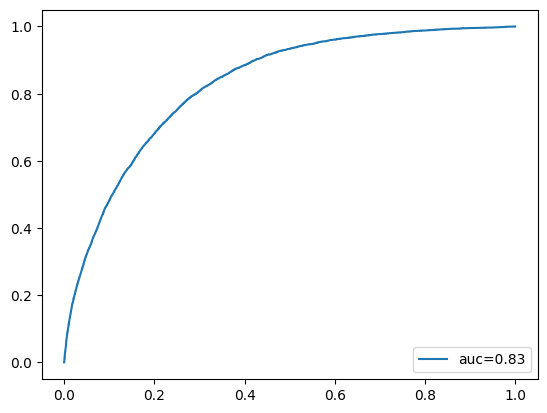

In [ ]:
y_pred_proba = modelRF.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba).round(3)
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.legend(loc=4)
plt.show()